In [200]:
import numpy as np
import scipy
import librosa
import random
import matplotlib.pyplot as plt

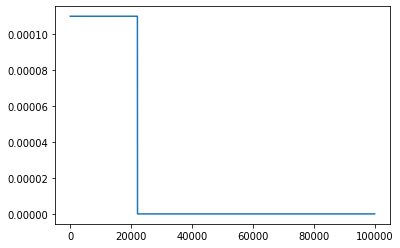

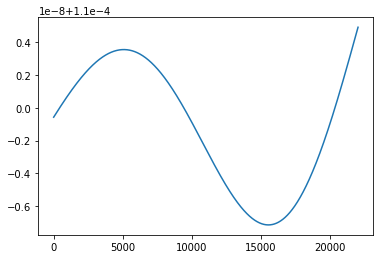

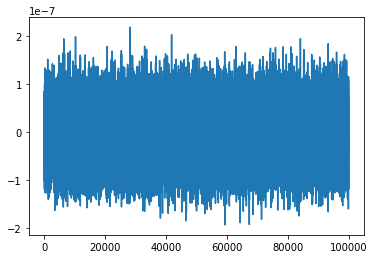

In [195]:
sr = 22050

def colored_noise(T, BW, N, std_std):
    '''
    Generate randomly frequency-selective noise.
    
    This function approximates a sampling from the space of "spectrally nice" noise distributions. Basically,
    it generates a random power spectrum, then runs the inverse Fourier transform on that power spectrum to
    get the noise. The random power spectrum is generated by randomly generating a Gaussian mixture model
    with `N` child distributions, each with randomly choosen mean and standard deviation.
    
    Given the noise bandwidth `bw`, the `N` child distributions' means are uniformly spread out
    across the bandwidth. Then, the standard deviation of each distribution is randomly choosen by
    sampling from a reflected normal distribution with mean zero and standard deviation `std_std`
    (reflected means absolute value, i.e. |N(0, `std_std`)|.
    
    Args:
        T:         number of samples of noise to generate
        bw:        bandwidth of the noise
        N:         number of Gaussians in the GMM
        //std_mean:  mean of the standard deviation sampling distribution
        std_std:   standard deviation of the standard deviation sampling distribution
    
    Returns:
        tdist:     noise in the time domain
    '''
    
    bw = T
    
    # Randomly generate parameters of the GMM
    fsteps = bw / (N + 1)
    means = np.array(range(-4, N + 5)) * fsteps
    stds = np.abs(np.random.normal(fsteps, std_std, N + 9))
    
    # Sample from the GMM
    pdist = np.zeros(bw)
    for i in range(N+9):
        pdist += scipy.stats.norm.pdf(np.array(range(bw)), means[i], stds[i])
        
    pdist[BW:] = 0
    
    plt.plot(range(len(pdist)), pdist)
    plt.figure()
    plt.plot(range(BW), pdist[:BW])
    
    # Mix with random phase complex exponentials
    c = 1 / np.sum(pdist)
    pdist = c * pdist
    Cs = pdist * np.exp(1.0j * np.random.uniform(0, 2 * np.pi, pdist.size))
    
    # Return the time domain noise signal
    tdist = np.fft.ifft(Cs)
    return tdist

T = 100000
tdist = colored_noise(T, sr, 10, 2)
plt.figure()
plt.plot(np.array(range(T)).T, tdist)
plt.show()

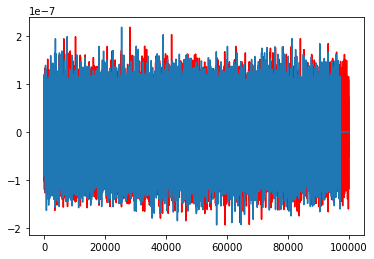

In [202]:
def t_shift(sig, sr, smax):
    '''
    Shift the signal `sig` in the time domain by a random number of samples.
    
    
    Shifts from [0, `smax`] seconds given `sr` sampling rate, shifting in
    random direction.
    
    Args:
        sig:     signal to shift
        sr:      sampling rate (Hz)
        smax:    max number of seconds to shift
        
    Returns:
        ssig:    shifted signal
    '''
    
    shift = np.random.randint(sr * smax)
    shift = shift if bool(random.getrandbits(1)) else -shift
    
    ssig = np.roll(sig, shift)
    
    if shift > 0:
        ssig[:shift] = 0
    else:
        ssig[shift:] = 0
    
    return ssig

plt.plot(tdist, 'r')
plt.plot(t_shift(tdist, sr, 1))
plt.show()

/home/rytse/anaconda3/envs/ngspc/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


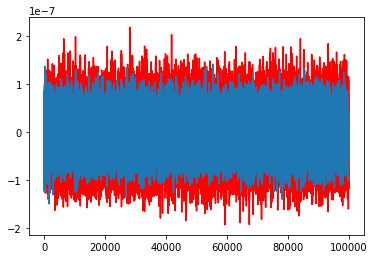

In [206]:
def f_shift(sig, sr, mpf):
    '''
    Shift the signal `sig` in the frequency domain by a random number of semitones
    
    
    Shifts from [-`mpf`, `mpf`] semitones given `sr` sampling rate, shifting in
    `sd` direction ('left', 'right', or 'both').
    
    Args:
        sig:     signal to shift
        sr:      sampling rate (Hz)
        smax:    max number of semitones to shift
        
    Returns:
        ssig:    shifted signal
    '''
    
    pf = np.random.randint(-mpf, mpf)
    return librosa.effects.pitch_shift(np.asfortranarray(sig.real), sr, pf)

plt.plot(tdist, 'r')
plt.plot(f_shift(tdist, sr, 4))
plt.show()

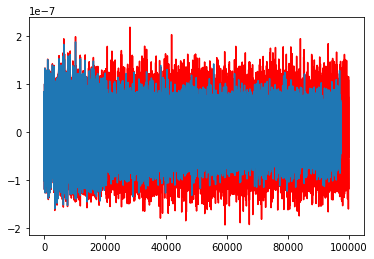

In [210]:
def stretch(sig, ms):
    '''
    Stretch the signal `sig` in the time domain by a random factor.
    
    
    Stretches by a ratio between [1-`ms`, 1+`ms`].
    
    Args:
        sig:     signal to shift
        ms:      max stretch factor
        
    Returns:
        ssig:    stretched signal
    '''
    
    ss = np.random.normal()*ms + 1
    ss = 1 - ms if ss < 1 - ms else ss
    ss = 1 + ms if ss > 1 + ms else ss
    return librosa.effects.time_stretch(np.asfortranarray(sig.real), ss)

plt.plot(tdist, 'r')
plt.plot(stretch(tdist, 0.1))
plt.show()

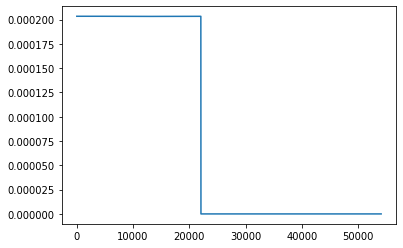

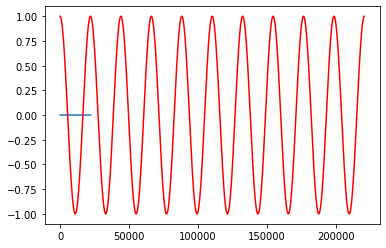

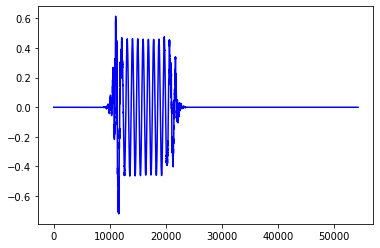

In [221]:
def aug(sig, sr):
    psig = np.concatenate((np.zeros(sr * 1), sig, np.zeros(sr * 1)))
    asig = psig + colored_noise(len(psig), sr, 10, 2)
    tsig = t_shift(asig, sr, 0.5)
    fsig = f_shift(tsig, sr, 3)
    ssig = stretch(fsig, 0.05)
    
    return ssig

ts = np.linspace(0, sr * 10, 10000)
sig = np.cos(ts * 2 * np.pi / (sr))
asig = aug(sig, sr)

plt.plot(ts, sig, 'r')
plt.figure()
plt.plot(asig, 'b')   